# Desafío - Análisis lineal discriminante

● Para realizar este desafío debes haber estudiado previamente todo el material disponibilizado correspondiente a la unidad.

● Una vez terminado el desafío, comprime la carpeta que contiene el desarrollo de los requerimientos solicitados y sube el .zip en el LMS.

● Desarrollo desafío:
    
    ○ El desafío se debe desarrollar de manera Individual.
    
    ○ Para la realización del desafío necesitarás apoyarte del archivo Apoyo Desafío - Análisis lineal discriminante.

## Requerimientos

Trabajaremos con una base de datos sobre clientes morosos de un banco. Dentro de ésta se registran las siguientes observaciones:

● `default:` Variable Binaria. Registra si el cliente entró en morosidad o no.

● `income:` Ingreso promedio declarado por el cliente.

● `balance:` total del saldo en la cuenta de crédito.

● `student:` Variable binaria. Registra si el cliente es estudiante o no.

## Ejercicio 1: Preparación de ambiente de trabajo

● Importe los módulos básicos para el análisis de datos.

● Importe las clases LabelEncoder, StandardScaler y LabelBinarizer de preprocessing.

● Importe las funciones train_test_split y cross_val_score de model_selection.

● Importe la función classification_report de metrics.

● Importe las clases LinearDiscriminantAnalysis y QuadraticDiscriminantAnalysis.

● Agregue la base de datos en el ambiente de trabajo.

● Inspeccione la distribución de cada atributo.

In [1]:
# importaciones
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import func as gfx

# Importaciones especificas de este desafio.
from imblearn.over_sampling import SMOTE
from collections import Counter

#sklearn
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, LabelBinarizer
from sklearn.metrics import classification_report

labelencoder = LabelEncoder()
warnings.simplefilter('ignore')
plt.rcParams['figure.figsize'] = (10,6)
plt.style.use('seaborn')

In [2]:
df=pd.read_csv('default_credit.csv').drop(columns='index')
df.head()

,default,student,balance,income
0,No,No,729.526495,44361.625074
1,No,Yes,817.180407,12106.134700
2,No,No,1073.549164,31767.138947
3,No,No,529.250605,35704.493935
4,No,No,785.655883,38463.495879


In [3]:
df.describe()

,balance,income
count,10000.000000,10000.000000
mean,835.374886,33516.981876
std,483.714985,13336.639563
min,0.000000,771.967729
25%,481.731105,21340.462903
50%,823.636973,34552.644802
75%,1166.308386,43807.729272
max,2654.322576,73554.233495


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   default  10000 non-null  object 
 1   student  10000 non-null  object 
 2   balance  10000 non-null  float64
 3   income   10000 non-null  float64
dtypes: float64(2), object(2)
memory usage: 312.6+ KB


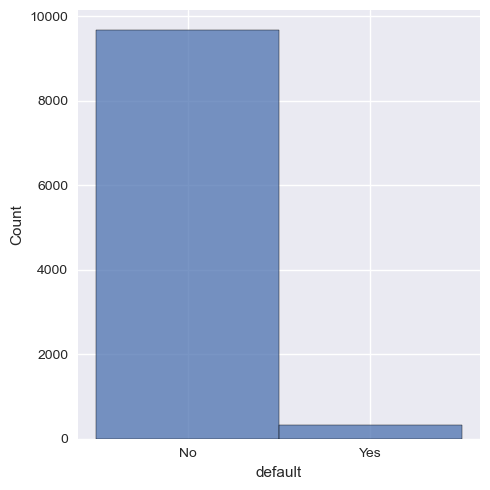

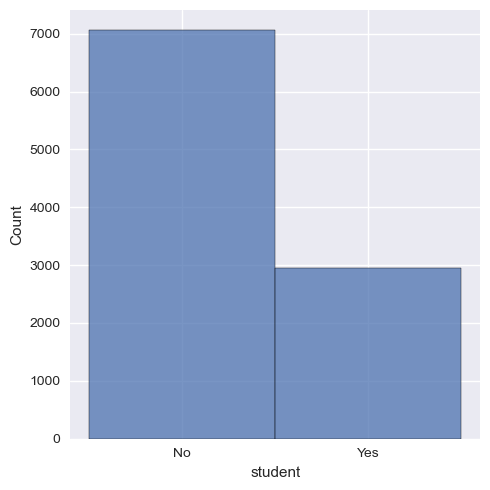

In [5]:
sns.displot(data=df, x="default")
sns.displot(data=df, x="student")

In [6]:
name_vars = ['balance', 'income']

for i in range(len(name_vars)):
        gfx.dist_box(df[name_vars[i]])

## Ejercicio 2: Modelo base

● Recuerde que los modelos de sklearn no soportan datos que no sean numéricos. Transforme los atributos pertinentes con LabelEncoder.

● Genere muestras de validación y entrenamiento, reservando un 33% de los datos como validación.

● Genere un modelo con LinearDiscriminantAnalysis sin modificar los hiper parámetros. Genere métricas de evaluación utilizando classification_report.

● Comente sobre cuál es el desempeño del modelo en cada clase, así como en general.

In [7]:
df_discriminant = df

In [8]:
df_discriminant.head(5)

,default,student,balance,income
0,No,No,729.526495,44361.625074
1,No,Yes,817.180407,12106.134700
2,No,No,1073.549164,31767.138947
3,No,No,529.250605,35704.493935
4,No,No,785.655883,38463.495879


In [9]:
df_discriminant['default'] = labelencoder.fit_transform(df_discriminant['default'])
df_discriminant['student'] = labelencoder.fit_transform(df_discriminant['student'])
df_discriminant.head(5)

,default,student,balance,income
0,0,0,729.526495,44361.625074
1,0,1,817.180407,12106.134700
2,0,0,1073.549164,31767.138947
3,0,0,529.250605,35704.493935
4,0,0,785.655883,38463.495879


In [10]:
df_discriminant['default'].value_counts()

0    9667
1     333
Name: default, dtype: int64

In [11]:
X_train, X_test, y_train, y_test = train_test_split(df_discriminant.loc[:, 'student':'income'], df_discriminant['default'], test_size = .33, random_state = 2404)
X_train.shape

(6700, 3)

In [12]:
clf_discriminant = LinearDiscriminantAnalysis()
clf_discriminant.fit(X_train, y_train)

LinearDiscriminantAnalysis()

In [13]:
# metricas de desempeño
predic = clf_discriminant.predict(X_test)
print(classification_report(y_test, predic))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99      3192
           1       0.82      0.21      0.34       108

    accuracy                           0.97      3300
   macro avg       0.90      0.61      0.66      3300
weighted avg       0.97      0.97      0.96      3300



El modelo es muy bueno prediciendo clientes no morosos, pero muy malo evaluando clientes morosos. Se recomienda ampliar la cantidad de registros, ya que esta muy desbalanceada entre clientes no morosos y morosos. 
El modelo predice de buena forma los ***`1`*** (),pero con poca cantidad, no asi el resto de las metricas.

# Ejercicio 3: Refactorización 1 - información a priori


● Dado que trabajamos con modelos generativos, podemos incluir información exógena. Para este caso agregaremos dos distribuciones:

    ○ Asumamos que hay un 50/50 de morosos y no morosos.
    
    ○ Asumamos que hay un 60/40 de morosos y no morosos.
    
● Por cada modelo, reporte las métricas de clasificación.

In [14]:
# Asumamos que hay un 50/50 de morosos y no morosos.
ld_1 = LinearDiscriminantAnalysis(priors = [50,50])
ld_1.fit(X_train, y_train)

LinearDiscriminantAnalysis(priors=[50, 50])

In [15]:
# metricas de desempeño
predict_1 = ld_1.predict(X_test)
print(classification_report(y_test, predict_1))

              precision    recall  f1-score   support

           0       1.00      0.84      0.91      3192
           1       0.16      0.92      0.27       108

    accuracy                           0.84      3300
   macro avg       0.58      0.88      0.59      3300
weighted avg       0.97      0.84      0.89      3300



In [16]:
#Asumamos que hay un 60/40 de morosos y no morosos.
ld_2 = LinearDiscriminantAnalysis(priors = [60,40])
ld_2.fit(X_train, y_train)

LinearDiscriminantAnalysis(priors=[60, 40])

In [17]:
# metricas de desempeño
predict_2 = ld_2.predict(X_test)
print(classification_report(y_test, predict_2))

              precision    recall  f1-score   support

           0       1.00      0.88      0.93      3192
           1       0.19      0.87      0.31       108

    accuracy                           0.88      3300
   macro avg       0.59      0.87      0.62      3300
weighted avg       0.97      0.88      0.91      3300



# Ejercicio 4: Refactorización 2 - oversampling

## Digresión: Synthetic Over(Under)Sampling

● Por lo general podemos intentar aliviar el problema del desbalance de clases mediante la ponderación dentro del algoritmo. Otra alternativa es el muestreo con reemplazo dentro de los conjuntos de entrenamiento. Estos métodos clásicos se conocen como ***`Oversampling`*** cuando repetimos registros aleatorios de la clase minoritaria, y ***`Undersampling`*** cuando eliminamos aleatoriamente registros de la clase mayoritaria.

● Un contratiempo de estos métodos clásicos es que pueden replicar información sesgada que afecte el desempeño de generalización del modelo. Si los datos son malos, estaremos replicando estas fallas.

● Otra solución es generar ejemplos de entrenamiento sintéticos mediante el entrenamiento de ejemplos de la clase minoritaria. A grandes rasgos la solución funciona de la siguiente forma: En función a un subconjunto de datos correspondientes a la clase minoritaria, entrenamos algún modelo no supervisado o generativo como Naive Bayes, KMeans o KNearestNeighbors para generar representaciones sintéticas de los datos en el espacio de atributos de la clase específica mediante 𝑥 es un ejemplo de 𝑛𝑢𝑒𝑣𝑜−𝑒𝑗𝑒𝑚𝑝𝑙𝑜 = 𝑥 𝑖 + λ(𝑥 𝑧𝑖 − 𝑥 𝑖 ) entrenamiento de la clase minoritaria y λ es un parámetro de interpolación aleatorio λ ∼ 𝑈𝑛𝑖𝑓𝑜𝑟𝑚𝑒(0, 1).

● Uno de los problemas más graves de esta base de datos, es el fuerte desbalance entre clases. Ahora generaremos observaciones sintéticas mediante SMOTE (Synthetic Minority Oversampling Technique). Para ello, debemos agregar el paquete a nuestro ambiente virtual. En nuestro terminal agregamos `conda install -c conda-forge imbalanced-learn`. Incorpore SMOTE en el ambiente de trabajo con la siguiente sintáxis `from imblearn.over_sampling import SMOTE`.

● Para implementar oversampling, debemos generar nuevos objetos que representan nuestra muestra de entrenamiento incrementada artificialmente. Para ello implemente la siguiente sintaxis: 

```
from imblearn.over_sampling import SMOTE
# Instanciamos la clase 
oversampler = SMOTE(random_state=11238, ratio='minority')
# generamos el eversampling de la matriz de entrenamiento y
X_train_oversamp, y_train_oversamp = oversampler.fit_sample(X_train,y_train) 
```

● Vuelva a entrenar el modelo con los datos aumentados de forma artificial y comente sobre su desempeño.

In [18]:
# Instanciamos la clase SMOTE para samplear la muestra minoritaria
oversampler = SMOTE(random_state=2404, sampling_strategy='minority') # da error en el codigo ratio='minority'
# Generamos el oversampling
X_train_oversamp, y_train_oversamp = oversampler.fit_resample(X_train,y_train)

In [19]:
print(f'''Revisión de muestra de entrenamiento sin oversampling
Datos de validacion {sorted(Counter(y_train).items())}

Revisión de muestra de entrenamiento con oversampling
{sorted(Counter(y_train_oversamp).items())}''')

Revisión de muestra de entrenamiento sin oversampling
Datos de validacion [(0, 6475), (1, 225)]

Revisión de muestra de entrenamiento con oversampling
[(0, 6475), (1, 6475)]


In [20]:
pre_oversample = LinearDiscriminantAnalysis()
pre_oversample.fit(X_train_oversamp, y_train_oversamp)

LinearDiscriminantAnalysis()

In [21]:
predic_oversample = pre_oversample.predict(X_test)
print(classification_report(y_test, predic_oversample))

              precision    recall  f1-score   support

           0       1.00      0.85      0.92      3192
           1       0.17      0.91      0.28       108

    accuracy                           0.85      3300
   macro avg       0.58      0.88      0.60      3300
weighted avg       0.97      0.85      0.89      3300



# Ejercicio 5: Refactorización 3 - QDA

● Por último, implemente un modelo ***`QuadraticDiscriminantAnalysis`*** con los datos aumentados artificialmente. Genere las métricas de desempeño.

● Comente a grandes rasgos sobre el mejor modelo en su capacidad predictiva.

In [22]:
model_q = QuadraticDiscriminantAnalysis()
model_q.fit(X_train_oversamp,y_train_oversamp)

QuadraticDiscriminantAnalysis()

In [23]:
predict_q = model_q.predict(X_test)
print(classification_report(y_test, predict_q))

              precision    recall  f1-score   support

           0       0.99      0.87      0.93      3192
           1       0.18      0.87      0.30       108

    accuracy                           0.87      3300
   macro avg       0.59      0.87      0.61      3300
weighted avg       0.97      0.87      0.91      3300



En conclusión las muestras de entrenamiento y validacion en general quedan muy desbalanceadas que por mas que intentamos predecir los mororos no conseguimos resultados optimos en las predicciones. Todos los modelos, y cada una de la sinteticacion de los datos no representan grandes mejoras entre ellos. Si, los modelos tienen una buena prediccion para la clase 0, incluso sin modificar los hiperparametros ni sintetizar a ellos mismos. Se puede observar que la unica mejora en los modelos al cambiar los hiperparametros es `recall`, pero el resto de las metricas continuan siendo malas.